# 시계열 분해 및 Prophet 모형

## 1. 시계열 분해 

- 15~21년도의 금 시세를 퀀들 사이트에서 불러와 월별 가격으로 리샘플한 후 이동 평균과 표준편차를 시각화한다.

In [23]:
import pandas as pd
import quandl
from statsmodels.tsa.seasonal import seasonal_decompose

In [24]:
quandl_key = 'AR5J41pEzA-6zZvVBYy9'
quandl.ApiConfig.api_key = quandl_key

df_gold = quandl.get(dataset='WGC/GOLD_MONAVG_USD',start_date='2015-01-01',end_date='2021-12-31')
df_gold.head()

,Value
Date,
2015-01-30,1251.85
2015-01-31,1251.85
2015-02-27,1227.19
2015-02-28,1227.19
2015-03-31,1178.63


In [25]:
df = df_gold.resample('M').last()

<AxesSubplot:title={'center':'Gold Price'}, xlabel='Date'>

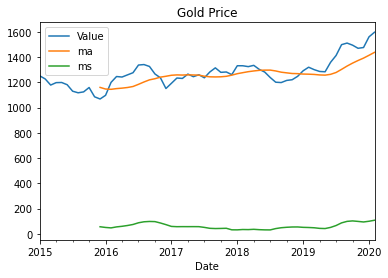

In [26]:
window_size=12
df['ma'] = df.Value.rolling(window=window_size).mean()
df['ms'] = df.Value.rolling(window=window_size).std()
df.plot(title='Gold Price')

- 위의 그림을 보면 이동평균에 약간의 비선형적인 증가 패턴이 보인다.

Text(0.5, 0.98, 'Multiplicative Decomposition')

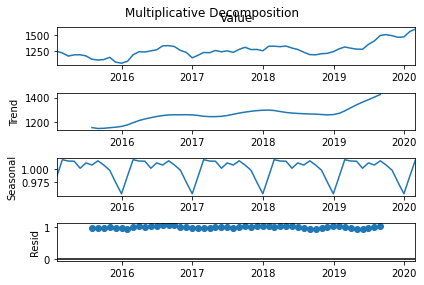

In [27]:
decomposition_results = seasonal_decompose(df.Value,model='multiplicative')
decomposition_results.plot().suptitle('Multiplicative Decomposition')

- 위의 그림을 통해 추세, 계절성, 랜덤성을 볼수 있다. 점진적으로 증가하는 추세를 보이며, 계절별로 주기성이 뚜렷하게 보인다. 랜덤성(잔차)는 항상 일정하게 유지되고 있다.

## 2. Prophet 모형

15~19년도의 일별 금시세를 퀀들 사이트에서 불러와서 Prophet 모형을 통해 시계열 분해를 진행해 본다.

In [28]:
# 참고로 Prophet 모형은 램 성능이 좋지 않은 컴퓨터에서는 돌아가지 않는다.
# python 3.6 버전에서 실행가능
# conda install pandas
# pip install cython
# pip install pystan
# conda install -c conda-forge fbprophet
# pip install --upgrade plotly
import pandas as pd
import quandl

import seaborn as sns
from fbprophet import Prophet

In [29]:
# import logging
# logging.getLogger('fbprophet').setLevel(logging.WARNING)

In [30]:
daily_gold = quandl.get(dataset='WGC/GOLD_DAILY_USD',start_date='2015-01-01',end_date='2019-12-31')
daily_gold.reset_index(drop=False,inplace=True)
daily_gold.tail()

,Date,Value
1299,2019-12-25,1482.10
1300,2019-12-26,1482.10
1301,2019-12-27,1511.50
1302,2019-12-30,1514.75
1303,2019-12-31,1514.75


In [31]:
daily_gold.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1304 entries, 0 to 1303
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    1304 non-null   datetime64[ns]
 1   Value   1304 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 20.5 KB


In [32]:
# ds, y로 column명을 변경해줘야 모형이 돌아감
daily_gold.rename(columns={'Date':'ds','Value':'y'},inplace=True)

In [33]:
# train, test 분할
train_indices = daily_gold.ds.apply(lambda x:x.year) < 2019
gold_train = daily_gold.loc[train_indices].dropna()
gold_test = daily_gold.loc[~train_indices].reset_index(drop=True)

In [34]:
model = Prophet(seasonality_mode='additive') # 기본적으로 주별,연도별 특성 제공
model.add_seasonality(name='monthly',period=30.5,fourier_order=5) #월별 특성 추가
model.fit(gold_train)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


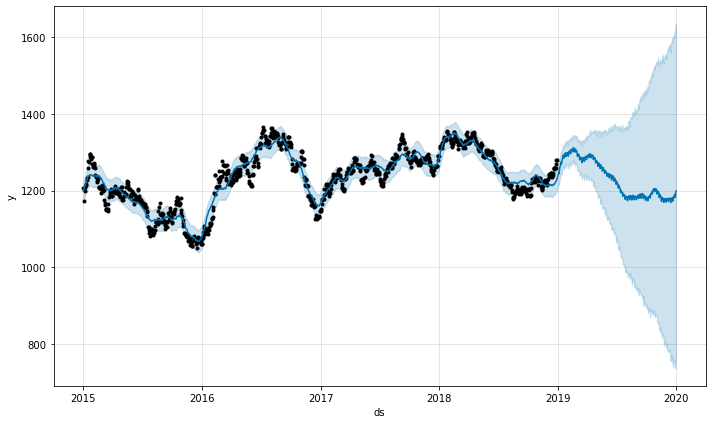

In [42]:
gold_future = model.make_future_dataframe(periods=365)
gold_pred = model.predict(gold_future)
fig = model.plot(gold_pred)

검정색 점이 실제 금 시세를 나타낸 값이고, 파란색 선이 prophet 모형으로 예측한 값이다.

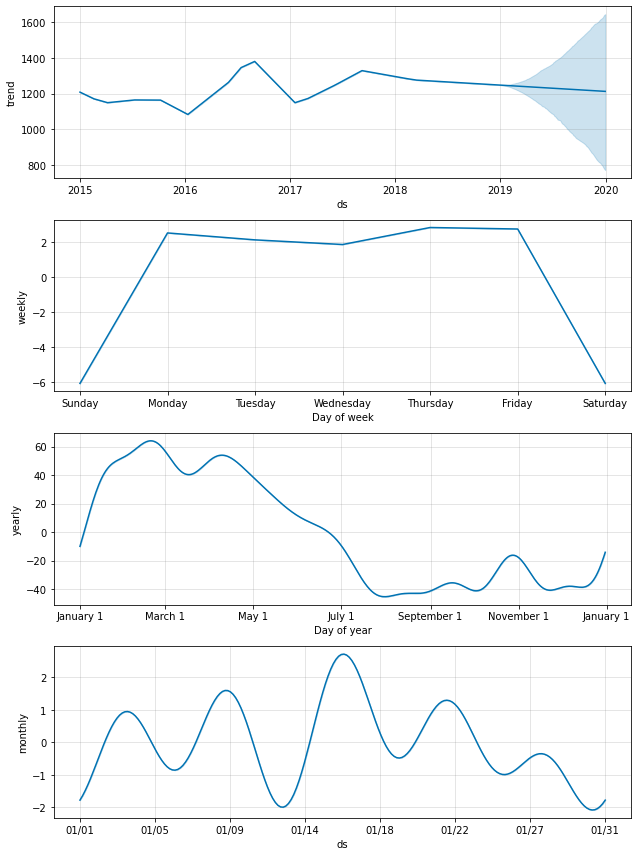

In [43]:
fig2 = model.plot_components(gold_pred)

- 위의 그림을 통해 추세, 주별, 연도별, 월별 패턴을 파악할 수 있다. 전체적인 추세는 비슷하게 흘러간다. 연간 패턴을 볼 때, 금 가격은 3~5월에 높아지고 연말까지 하락하고 연초에는 조금씩 상승하는 모습을 보인다. 월별 패턴은 규모가 크지 않은 약간의 움직임만 있는 것으로 보인다. 주별 패턴은 주말에는 시세가 나오지 않기 때문에 그 부분을 빼고 보면, 거의 패턴이 없는 것으로 보인다. 

In [44]:
gold_pred.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,monthly,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2015-01-01,1208.327391,1172.965083,1225.245782,1208.327391,1208.327391,-9.391078,-9.391078,-9.391078,-0.587579,...,2.854359,2.854359,2.854359,-11.657859,-11.657859,-11.657859,0.0,0.0,0.0,1198.936313
1,2015-01-02,1207.541248,1175.497172,1229.666930,1207.541248,1207.541248,-4.871964,-4.871964,-4.871964,0.629967,...,2.767677,2.767677,2.767677,-8.269608,-8.269608,-8.269608,0.0,0.0,0.0,1202.669284
2,2015-01-05,1205.182819,1179.297258,1235.926432,1205.182819,1205.182819,4.222759,4.222759,4.222759,-0.720332,...,2.541759,2.541759,2.541759,2.401333,2.401333,2.401333,0.0,0.0,0.0,1209.405579
3,2015-01-06,1204.396677,1183.268670,1238.663479,1204.396677,1204.396677,7.470604,7.470604,7.470604,-0.696604,...,2.144548,2.144548,2.144548,6.022660,6.022660,6.022660,0.0,0.0,0.0,1211.867280
4,2015-01-07,1203.610534,1189.462264,1243.042386,1203.610534,1203.610534,11.844925,11.844925,11.844925,0.343510,...,1.878369,1.878369,1.878369,9.623047,9.623047,9.623047,0.0,0.0,0.0,1215.455459


In [45]:
selected_columns = ['ds', 'yhat_lower', 'yhat_upper', 'yhat']

gold_pred = gold_pred.loc[:, selected_columns].reset_index(drop=True)
gold_test = gold_test.merge(df_pred, on=['ds'], how='left')
gold_test.ds = pd.to_datetime(gold_test.ds)
gold_test.set_index('ds', inplace=True)

In [46]:
gold_test.head()

,y,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,monthly,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
ds,,,,,,,,,,,,,,,,,,,,,
2019-01-01,1279.00,1247.757722,1210.686383,1264.028262,1247.757722,1247.757722,-10.885472,-10.885472,-10.885472,-1.372162,...,2.144548,2.144548,2.144548,-11.657859,-11.657859,-11.657859,0.0,0.0,0.0,1236.872250
2019-01-02,1282.90,1247.661165,1210.997859,1268.343124,1247.661165,1247.661165,-8.436681,-8.436681,-8.436681,-2.045443,...,1.878369,1.878369,1.878369,-8.269608,-8.269608,-8.269608,0.0,0.0,0.0,1239.224484
2019-01-03,1290.45,1247.564608,1216.497510,1273.583980,1247.564608,1247.564608,-3.702328,-3.702328,-3.702328,-1.780123,...,2.854359,2.854359,2.854359,-4.776564,-4.776564,-4.776564,0.0,0.0,0.0,1243.862280
2019-01-04,1279.90,1247.468051,1220.799508,1276.430335,1247.468051,1247.468051,0.971018,0.971018,0.971018,-0.587579,...,2.767677,2.767677,2.767677,-1.209080,-1.209080,-1.209080,0.0,0.0,0.0,1248.439069
2019-01-07,1292.20,1247.178379,1231.035100,1289.479489,1247.178379,1247.178379,12.320772,12.320772,12.320772,0.155966,...,2.541759,2.541759,2.541759,9.623047,9.623047,9.623047,0.0,0.0,0.0,1259.499151


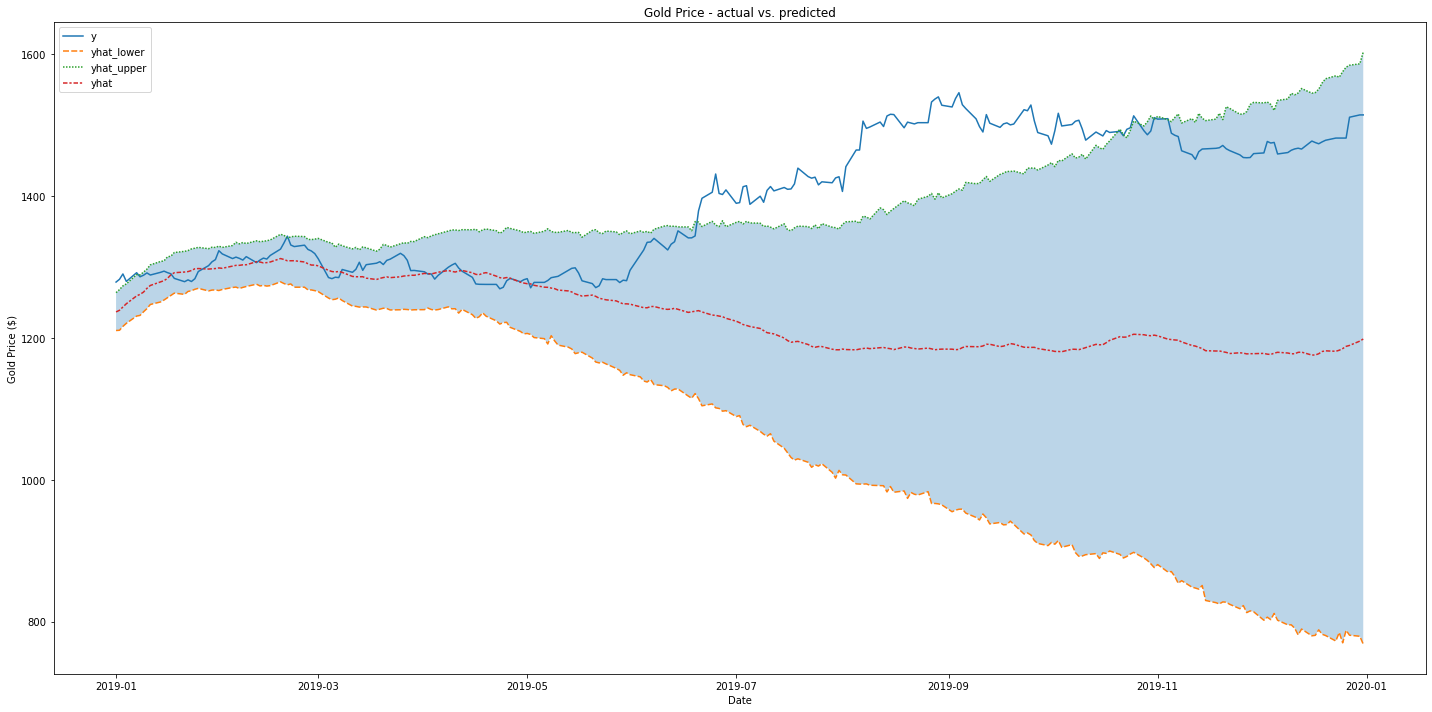

In [57]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(20,10))
ax = sns.lineplot(data=gold_test[['y', 'yhat_lower', 'yhat_upper', 'yhat']])
ax.fill_between(gold_test.index,gold_test.yhat_lower,gold_test.yhat_upper,alpha=0.3) #그래프 영역 채우기
ax.set(title='Gold Price - actual vs. predicted', xlabel='Date', ylabel='Gold Price ($)')

plt.tight_layout()
plt.show()

위의 모형이 2019년 기간에 신뢰구간을 크게 벗어나게 예측함을 알 수 있다.